### RetiNet: A custom CNN on Kaggle and IDRiD Dataset

In [ ]:
# import the necessary Deep learning packages
import tensorflow as tf
import keras
from keras import backend as K
from keras.backend import tensorflow_backend

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2

#preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle,class_weight,to_categorical
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report
from keras.preprocessing.image import img_to_array,array_to_img, ImageDataGenerator,load_img
from keras import  regularizers

#modelcreation libraries
from keras.models import Sequential,Model, load_model, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D,Activation,Flatten,Dropout,Dense, Average, concatenate
from keras.layers import 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorboardcolab import  TensorBoardColab, TensorBoardColabCallback

#importing pretrained models
from keras.applications.vgg16 import  VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.utils.vis_utils import plot_model

#import data read/write packages
import glob
import os
from tqdm import tqdm
import itertools

## required for efficient GPU use
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

Using TensorFlow backend.


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/dilab")

In [ ]:
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://411bd5f6.ngrok.io


In [ ]:
img_size = 224
batch_size = 32
classes = ['Grade: 0', 'Grade: 1', 'Grade: 2', 'Grade: 3','Grade: 4']
epochs = 500
num_classes = 5
# model_type = 'balkagid_resnet18'
model_type = 'balkagid_normcnn'

## Paths for IDRID Dataset

In [ ]:
train_path = '.Idrid/B. Disease Grading/1. Original Images/a. Training Set/*.jpg'
test_path = '.Idrid/B. Disease Grading/1. Original Images/b. Testing Set/*jpg'
train_label_path = '.Idrid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
test_label_path = '.Idrid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'

## Path for Messidor Dataset

In [ ]:
messi_data_path = './messidor/data/'

## Function to read Messidor data

In [ ]:
def augment():
    
    rot_angles = np.array([-5,5,0,0,0])
    data_gen = ImageDataGenerator(
            rotation_range= np.random.choice(rot_angles,size=1)[0],
            width_shift_range=0.01,
            height_shift_range=0.01,
            horizontal_flip=True,
            vertical_flip= True
            )
    return data_gen

In [ ]:
#COLOR CLAHE FUNC

def enhance(image, clip_limit=3):
  
    # convert image to LAB color model

    image = np.array(image, dtype = np.uint8)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # split the image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
   
    cl = clahe.apply(l_channel)
    
    # merge the CLAHE enhanced L channel with the original A and B channel
    merged_channels = cv2.merge((cl, a_channel, b_channel))

    # convert iamge from LAB color model back to RGB color model
    final_image = cv2.cvtColor(merged_channels, cv2.COLOR_LAB2BGR)
    
    final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

   
    return (final_image)

In [ ]:
def weighted_sampling(data,labels):
    
    data_per_class = []
    data_dist = plt.hist(labels,bins=num_classes)[0]
    maj_class = np.argmax(data_dist)
    max_size = int(data_dist[maj_class])
    
    print("Majority class is {}\nData Distribution : {}".format(maj_class,data_dist))
    
    for i in range(num_classes):
        
        if(i!=maj_class):
            
            data_per_class = (data[labels==i])
            data_gen = augment()
            data_gen.fit(data_per_class)
            class_size = len(data_per_class)
            
            if(class_size<(max_size-class_size)):
                for k in range(int((max_size-class_size) // class_size)+1):
                    img_gen = data_gen.flow(data_per_class,batch_size=(max_size-class_size))
                    if(k==0):
                      print(next(img_gen).shape)
                      imags = next(img_gen)
                    else:
                      imags = np.vstack((imags,(next(img_gen))))
#                 print(imags.shape)
            else:
                img_gen = data_gen.flow(data_per_class,batch_size=(max_size-class_size))
                imags = next(img_gen)
                
            
            data = np.vstack((data,imags[:(max_size-class_size)]))
#             print(data.shape)
            labels = np.concatenate((labels,np.ones(max_size-class_size)*i))
#             print(labels.shape)
            shuffled_index = np.arange(len(data))
            np.random.shuffle(shuffled_index)
            data = data[shuffled_index]
            labels = labels[shuffled_index]
            
    return data,labels

In [ ]:
def read_data(data_path=train_path,label_path=train_label_path,dir_path=None,istest=False,dataset='idrid',num_classes=5,weighted_sample=False):
    
    if(dataset=='Kaggle'):
        
        img_files = np.sort(glob.glob(data_path))

        x = np.array([np.array(load_img(img,target_size=(img_size,img_size,3))) 
                            for img in tqdm(img_files)])
        
        img_files_stripped = [img_file.strip(kag_path) for img_file in img_files]
        
        labels = labels[np.isin(label_df.iloc[:,0].values,img_files_stripped)]

        
    elif(dataset=='messidor' and dir_path is not None):
       
        for (sub_dirpath, sub_dirs, filenames) in walk(dir_path):
#             print(sub_dirs)
            break

        k = 0
        for sub_dir in tqdm(sub_dirs):
            
            sub_dir_path = os.path.join(dir_path,sub_dir)
            label_path = glob.glob("{}/*.xls".format(sub_dir_path))[0]
            img_paths =("{}/*.tif".format(sub_dir_path))
            img_files = np.sort(glob.glob(img_paths))
            df = pd.read_excel(label_path)

            if(k==0):
                x = (np.array([np.array(load_img(img,target_size=(img_size,img_size,3))) 
                                for img in (img_files)]))
                labels = df.iloc[:,2].values
                k+=1
            else:
                x = np.vstack((x,(np.array([img_to_array(load_img(img,target_size=(img_size,img_size,3))) 
                                    for img in (img_files)]))))
                labels = np.concatenate((labels,(df.iloc[:,2].values)))
                
    else:
            
        img_files = np.sort(glob.glob(data_path))

        x = np.array([np.array(load_img(img,target_size=(img_size,img_size,3))) 
                            for img in tqdm(img_files)])

        label_df = pd.read_csv(label_path)
        labels = label_df.iloc[:,1].values

    
    if(weighted_sample is True and istest is False and class_weights is not None):
          class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)
          x,labels = weighted_sampling(x,labels)
  
          print("Training cum Validation data size: {}".format(x.shape[0]))
          print("New Distribution after balancing:{} \n".format(plt.hist(labels,bins=num_classes)[0]))
        
    print(label_df.head())
    y= to_categorical(labels, num_classes=num_classes)

    return x,y,labels

In [ ]:
def split_data(data,labels,ratio=0.2):
    return train_test_split(data,labels,test_size=ratio,random_state=42)

In [ ]:
def create_model(num_classes=5):
    
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3),input_shape = (img_size, img_size, 3),
                            activation = 'relu'))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
   
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))
    
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    
    model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
  
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.25))
      
    model.add(Dense(512,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [ ]:
def inv3(fine_tune=False):
  
  based_model_last_block_layer_number = 249
  
  base_model = InceptionV3(include_top=False, weights='imagenet', input_shape = (img_size,img_size,3), pooling='avg', classes=num_classes)
  
  out = base_model.output
#   out = BatchNormalization()(out)
#   out = Activation('relu')(out)
  out = Dropout(0.7)(out)

  out = Dense(256,kernel_regularizer=regularizers.l2(0.01),
                kernel_initializer=keras.initializers.he_normal(seed=42),
                bias_initializer='zeros')(out)
    
  out  = BatchNormalization()(out)
  out = Activation('relu')(out)
  out = Dropout(0.7)(out)

  out = Dense(num_classes,kernel_initializer=keras.initializers.he_normal(seed=42),
              bias_initializer='zeros', activation='softmax')(out)

  model=Model(base_model.input,out)
  
  if(fine_tune):
    for layer in base_model.layers[:based_model_last_block_layer_number]:
      layer.trainable = False

    for layer in base_model.layers[based_model_last_block_layer_number:]:
        layer.trainable = True
  else:
     for layer in base_model.layers:
      layer.trainable = False
      
  print(model.summary())
  
  return model
   

In [ ]:
def diabnet():
    
    model = VGG16(weights='imagenet', include_top=False,input_shape=(img_size,img_size,3))
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x = (model.layers[14].output)
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', dilation_rate=(2,2), padding='same',kernel_initializer=keras.initializers.he_normal(seed=42),
                bias_initializer='zeros', kernel_regularizer=regularizers.l2(0), name='dil1_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', dilation_rate=(2,2), padding='same', kernel_initializer=keras.initializers.he_normal(seed=42),
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(0), name='dil1_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', dilation_rate=(2,2), padding='same', kernel_initializer=keras.initializers.he_normal(seed=42),
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(0), name='dil1_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='dil1_pool')(x)
    
    x = Dropout(0.5)(x)
    y = Dropout(0.5)(model.output)
    
#     y = model.output
    concat = concatenate([y, x], axis=-1)
 
    out = GlobalAveragePooling2D()(concat)
    out = Dropout(0.5)(out)
    
    
    out = Dense(512,kernel_regularizer=regularizers.l2(0),
                kernel_initializer=keras.initializers.he_normal(seed=42),
                bias_initializer='zeros')(out)
    
    out  = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.5)(out)
    
    out = Dense(num_classes,kernel_initializer=keras.initializers.he_normal(seed=42),
                bias_initializer='zeros', activation='softmax')(out)

    model=Model(model.input,out)
    
    w_conv1, b_conv1 = model.get_layer('block5_conv1').get_weights()
    w_conv2, b_conv2 = model.get_layer('block5_conv2').get_weights()
    w_conv3, b_conv3 = model.get_layer('block5_conv3').get_weights()
    
    model.get_layer('dil1_conv1').set_weights([w_conv1, b_conv1])
    model.get_layer('dil1_conv2').set_weights([w_conv2, b_conv2])
    model.get_layer('dil1_conv3').set_weights([w_conv3, b_conv3])

    for layer in model.layers[:12]:
        layer.trainable = False

    print(model.summary())
    
    (plot_model(model,'./diabnet.png'))
    
    return model

In [ ]:
def vgg_16(num_classes=5):
  
  
    #load vgg16 without dense layer and with theano dim ordering
    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(img_size,img_size,3))
    
    x = Dropout(0.5)(base_model.output)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    predictions = Dense(num_classes, activation = 'softmax')(x)
    
    comp_model = Model(input = base_model.input, output = predictions)
    return  comp_model

In [ ]:
def block(n_output, upscale=False):
  
    # n_output: number of feature maps in the block
    # upscale: should we use the 1x1 conv2d mapping for shortcut or not
    
    # keras functional api: return the function of type
    # Tensor -> Tensor
    def f(x):
        
        # H_l(x):
        # first pre-activation
        h = BatchNormalization()(x)
        h = Activation('relu')(h)
        # first convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0))(h)
        
        # second pre-activation
        h = BatchNormalization()(x)
        h = Activation('relu')(h)
        # second convolution
        h = Conv2D(kernel_size=3, filters=n_output, strides=1, padding='same', kernel_regularizer=regularizers.l2(0))(h)
        
        # f(x):
        if upscale:
            # 1x1 conv2d
            f = Conv2D(kernel_size=1, filters=n_output, strides=1, padding='same')(x)
        else:
            # identity
            f = x
        
        # F_l(x) = f(x) + H_l(x):
        return add([f, h])
    
    return f

In [ ]:
def res_18(num_classes=5):
  
      input_tensor = Input((img_size, img_size, 3))

      # first conv2d with post-activation to transform the input data to some reasonable form
      x = Conv2D(kernel_size=3, filters=16, strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      # F_1
      x = block(16)(x)
      # F_2
      x = block(16)(x)
       # F_3
      # F_3
      # H_3 is the function from the tensor of size 28x28x16 to the the tensor of size 28x28x32
      # and we can't add together tensors of inconsistent sizes, so we use upscale=True
      x = block(32, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
      # F_4
      x = block(32)(x)                     # !!! <------- Uncomment for local evaluation
      # F_5
      x = block(32)(x)                     # !!! <------- Uncomment for local evaluation

      # F_6
      x = block(48, upscale=True)(x)       # !!! <------- Uncomment for local evaluation
      # F_7
      x = block(48)(x)                     # !!! <------- Uncomment for local evaluation
      # last activation of the entire network's output
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      # average pooling across the channels
      # 28x28x48 -> 1x48
      x = GlobalAveragePooling2D()(x)

      # dropout for more robust learning
      x = Dropout(0.2)(x)

      x = Dense(512,kernel_regularizer=regularizers.l2(0))(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
    
      # last softmax layer
      x = Dense(units=num_classes, kernel_regularizer=regularizers.l2(0))(x)
      x = Activation('softmax')(x)

      model = Model(inputs=input_tensor, outputs=x)
#       model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      plot_model(model, to_file='resnet.png')
      return model

In [ ]:

def resnet_50(num_classes=5):
  
  
    #load vgg16 without dense layer and with theano dim ordering
    base_model = ResNet50(weights = None, include_top = False, input_shape=(img_size,img_size,3))
    
    x = base_model.output
    
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.5)(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.5)(x)
    
    predictions = Dense(num_classes, activation = 'softmax')(x)
    
    comp_model = Model(input = base_model.input, output = predictions)
    return  comp_model
    plot_model(model, to_file='resnet.png')

In [ ]:
def normal_cnn(num_classes=5):
    
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (5, 5),input_shape = (img_size, img_size, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))

    
    model.add(Conv2D(filters = 64, kernel_size = (5, 5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))

    
    model.add(Conv2D(filters = 64, kernel_size = (5, 5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))

    model.add(Conv2D(filters = 128, kernel_size = (5, 5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))

    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [ ]:
def modelA(num_classes=5):
    
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (3, 3),input_shape = (img_size, img_size, 3),
                            activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))
   
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))
    
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.25))

    
    model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))

#     model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation = 'relu'))
#     model.add(MaxPooling2D(pool_size = (2, 2)))


    model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
      
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes,activation='softmax'))
    
    return model

In [ ]:
def augment_data(rescale_factor=(1/255.0)):

    rot = np.array([-10,10,-10,10,5,-5])
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
            rotation_range= np.random.choice(rot,size=1)[0],
            rescale = rescale_factor,
#             horizontal_shift=0.01,
#             vertical_shift=0.01,
            vertical_flip = True,
            horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    
    test_datagen = ImageDataGenerator(rescale=rescale_factor)
    return train_datagen,test_datagen

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
def exp_decay(epoch):
      initial_lrate = 0.001
      k = 0.98
      lrate = initial_lrate*math.pow(k,epoch)
      return lrate

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
def load_dataset(filepath,num_classes=5):
    dict_ = np.load(filepath)
    x = dict_['a']
    y = dict_['b']
    
    if(y.shape[-1]!=num_classes):
       y = to_categorical(y,num_classes=num_classes)
    
    #shuffle data
    x, y = shuffle(x, y, random_state=42)
    
    print("Shape of Images : {} and Categorical labels :{} \n".format(x.shape,y.shape))
    return x,y   

In [ ]:
def preprocess(x):
    #preprocessing   CLAHE
    x = [enhance(x[i],2) for i in range(len(x))]
    x = np.array(x)
    return x

## Balancing and mixing of Kaggle and IDRID Dataset

Shape of Images : (14737, 224, 224, 3) and Categorical labels :(14737, 5) 

0    5421
1    2443
2    5292
3     873
4     708
Name: labels, dtype: int64


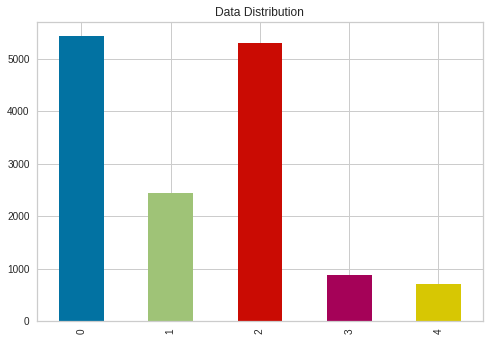

In [ ]:
# file_path = './kaggle/kaggle_data_total.npz'
# file_path = './Idrid/idrid_traindata.npz'
# file_path = './messidor_data.npz'
# file_path = './kaggle/kagid_mix_bal_data.npz'


# x,y = load_dataset(file_path,5)
# df = pd.DataFrame({'data' :list(x), 'labels': np.argmax(y,axis=-1)},  index=np.arange(len(x)))
# target_count = df['labels'].value_counts()
# target_count  = target_count.sort_index()
# print(target_count)


# target_count.plot(kind='bar', title='Data Distribution')
# plt.show()
# df_class_0 =df[ df['labels'] == 0]
# df_class_1 =df[ df['labels'] == 1]
# df_class_2 =df[ df['labels'] == 2]
# df_class_3 =df[ df['labels'] == 3]
# df_class_4 =df[ df['labels'] == 4]

# df_class_0_under = df_class_0.sample(1000)
# df_class_1_under = df_class_1.sample(1000)
# df_class_2_under = df_class_2.sample(1000)

# df_class_3_over = df_class_3.sample(1000, replace=True)
# df_class_4_over = df_class_4.sample(1000, replace=True)

# df_bal = pd.concat([df_class_0_under, df_class_1_under,df_class_2_under,df_class_3_over,df_class_4_over], axis=0)

# print('Random under plus over-sampling:')
# per_class_cts = df_bal['labels'].value_counts()
# print(per_class_cts)

# per_class_cts.plot(kind='bar', title='Count (target)')


# file_path = './Idrid/idrid_traindata.npz'
# x_idr,y_idr = load_dataset(file_path,5)

# df_idrid = pd.DataFrame({'data': list(x_idr),'labels':np.argmax(y_idr,axis=-1)})
# df_bal = pd.concat([df_bal,df_idrid],axis=0)
# df_bal['labels'].value_counts()

# x = [img for img in df_bal.iloc[:,0].values]
# y = to_categorical(df_bal['labels'].values)

# x= np.array(x)
# print(x.shape)
# y.shape

# np.savez_compressed('./kaggle/kagid_mix_bal_data', a=x,b=y)

In [ ]:
file_path = './kaggle/kagid_mix_bal_data.npz'
x,y  = load_dataset(file_path,5)
x = preprocess(x)

Shape of Images : (5413, 224, 224, 3) and Categorical labels :(5413, 5) 



In [ ]:
x_trval,x_test,y_trval,y_test = split_data(x,y,ratio=0.2)

In [ ]:
x_train,x_val,y_train,y_val = split_data(x,y,ratio=0.2)

In [ ]:
train_labels = np.argmax(y_train,axis=-1)
val_labels = np.argmax(y_val,axis=-1)
test_labels = np.argmax(y_test,axis=-1)

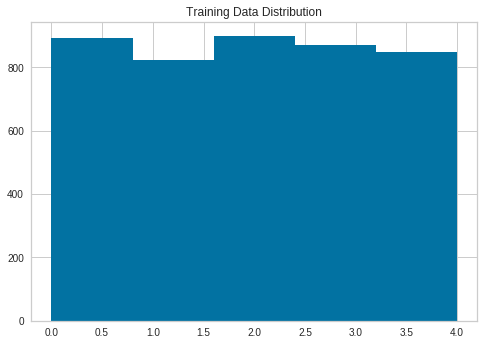

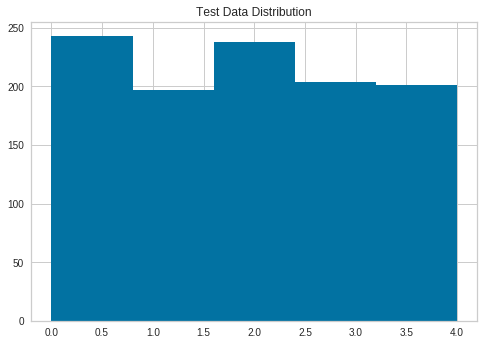

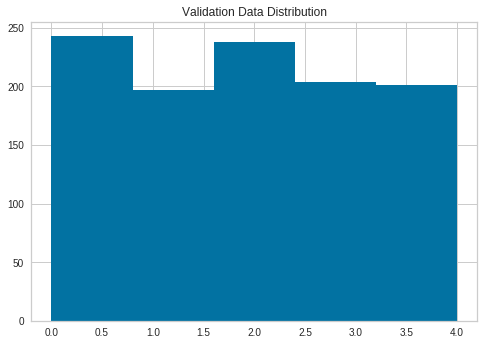

In [ ]:
plt.hist(train_labels, bins=num_classes)[0]
plt.title("Training Data Distribution")
plt.show()
plt.hist(test_labels,bins=num_classes)[0]
plt.title("Test Data Distribution")
plt.show()
plt.hist(val_labels,bins=num_classes)[0]
plt.title("Validation Data Distribution")
plt.show()

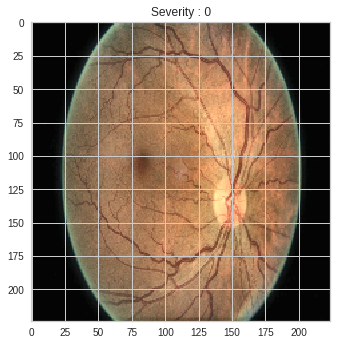

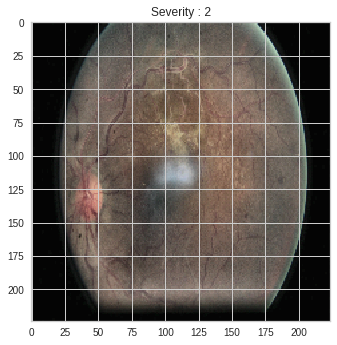

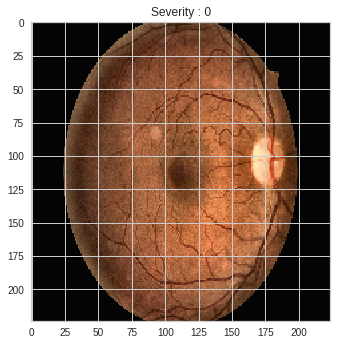

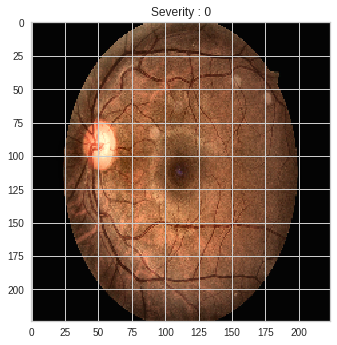

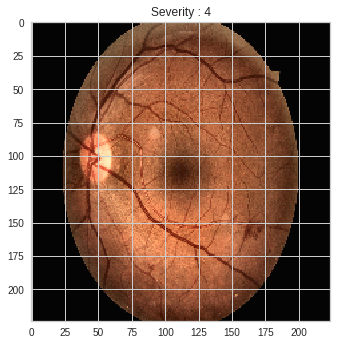

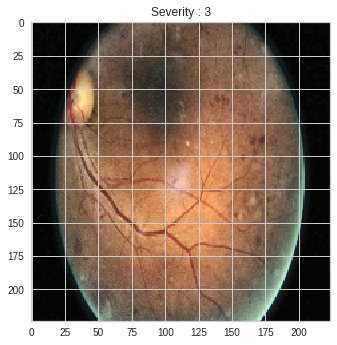

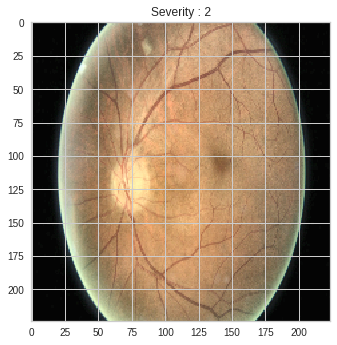

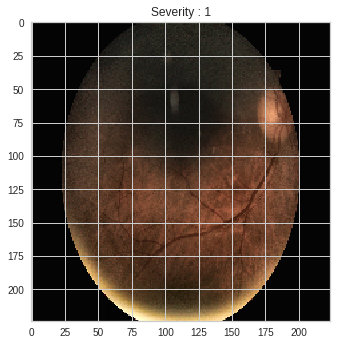

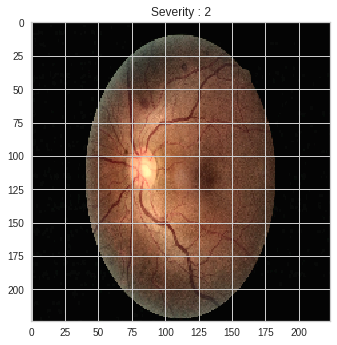

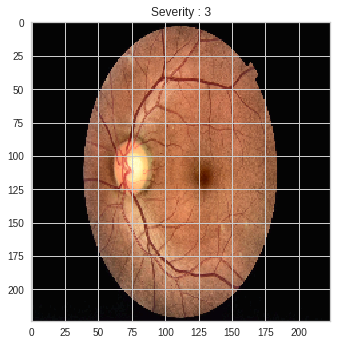

In [ ]:
for i in (np.random.randint(0,high=len(x_train),size=10)):
    
    plt.imshow(x_train[i])
    plt.title("Severity : {}".format((train_labels[i])))
    plt.show()

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_labels),train_labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9719416386083053,
 1: 1.0522478736330498,
 2: 0.9643652561247216,
 3: 0.9954022988505747,
 4: 1.0212264150943395}

In [ ]:
x_train.shape

(4330, 224, 224, 3)

In [ ]:
x_test.shape

(1083, 224, 224, 3)

In [ ]:
x_test = x_test.astype('float32')/255.0

In [ ]:
# define path to save model
model_path = './weights/weights_'+model_type+'.{epoch:02d}-{val_loss:.2f}.hdf5'
# prepare callbacks

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=50,
        mode='auto',
        verbose=1),
    
    ModelCheckpoint(model_path,
        monitor='val_loss', 
        save_best_only=True, 
        save_weights_only=True,
        mode='auto',
        verbose=1),
    
    TensorBoardColabCallback(tbc),
   
    keras.callbacks.History(),

   keras.callbacks.LearningRateScheduler(exp_decay)
#     ReduceLROnPlateau(monitor='val_loss', 
#                                             patience=5, 
#                                             verbose=1, 
#                                             factor=0.75, 
#                                             min_lr=0.000000001)
]

In [ ]:
model = normal_cnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 106, 64)      51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 106, 106, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 106, 106, 64)      0         
__________

In [ ]:
# img = cv2.imread('./resnet.png')
# plt.figure(figsize=(40,40))
# plt.imshow(img)

In [ ]:
train_size = x_train.shape[0]
val_size = x_val.shape[0]

In [ ]:
adam_ = keras.optimizers.Adam(lr = 3e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam_,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
train_datagen,val_datagen = augment_data()

In [ ]:
train_generator = train_datagen.flow(x_train,y_train,batch_size=batch_size,shuffle=True)

In [ ]:
val_generator = val_datagen.flow(x_val,y_val,batch_size=batch_size,shuffle=True)

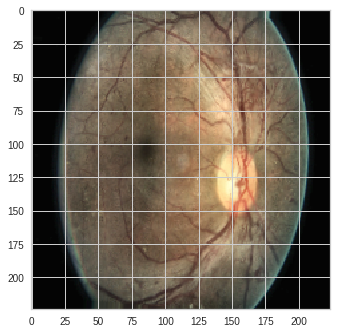

In [ ]:
plt.imshow(next(train_generator)[0][0])
plt.show()

In [ ]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
curr_epoc = 249
epochs = 500
batch_size=32

In [ ]:
# tbc=TensorBoardColab()

In [ ]:
# model_file = './weights/weights_balkagid_normcnn.111-1.14.hdf5'
# model_file = './weights/weights_balkagid_normcnn.92-0.95.hdf5'
# model_file = './weights/weights_balkagid_normcnn.195-0.91.hdf5'
# model_file = './weights/weights_balkagid_resnet18.396-1.09.hdf5'
# model.load_weights(model_file)

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_size // batch_size,
        epochs=epochs,
        initial_epoch=curr_epoc,
        validation_data=val_generator,
        validation_steps =  val_size // batch_size,
#         class_weight=class_weights,
         verbose=1,
        shuffle=True,
        callbacks = callbacks)

Epoch 250/500
135/135 [==============================] - 58s 427ms/step - loss: 0.4049 - acc: 0.8677 - val_loss: 1.0055 - val_acc: 0.5956

Epoch 00250: val_loss improved from inf to 1.00548, saving model to ./weights/weights_balkagid_normcnn.250-1.01.hdf5
Epoch 251/500
135/135 [==============================] - 54s 403ms/step - loss: 0.4101 - acc: 0.8688 - val_loss: 1.0149 - val_acc: 0.5985

Epoch 00251: val_loss did not improve from 1.00548
Epoch 252/500
135/135 [==============================] - 54s 403ms/step - loss: 0.4101 - acc: 0.8662 - val_loss: 1.0101 - val_acc: 0.5956

Epoch 00252: val_loss did not improve from 1.00548
Epoch 253/500
135/135 [==============================] - 54s 400ms/step - loss: 0.4070 - acc: 0.8606 - val_loss: 0.9788 - val_acc: 0.6004

Epoch 00253: val_loss improved from 1.00548 to 0.97883, saving model to ./weights/weights_balkagid_normcnn.253-0.98.hdf5
Epoch 254/500
135/135 [==============================] - 54s 400ms/step - loss: 0.4050 - acc: 0.8677 - v

In [ ]:
np.savez_compressed('./history_{}'.format(model_type), a=history.history)

In [ ]:
# plot_history(history)

In [ ]:
model.evaluate(x_test,y_test)

1083/1083 [==============================] - 2s 2ms/step


[0.9820388520303305, 0.589104339741824]

In [ ]:
# Evaluating the model with best weights obtained during training
def evaluate_model(x_test,y_test,trained_model,model_file):
  
  model = trained_model()
  print(model.summary())
  model.load_weights(model_file)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  scores = model.evaluate(x_test, y_test, verbose=1)
 
  print("Test Accuracy: %.2f%%" % (scores[1]*100))
  
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred,axis=-1)

  for i in range(4):
    plt.imshow(x_test[i])
    plt.title("Predicted : {} , Actual : {}".format(y_pred[i],test_labels[i]))
    plt.show()

  y_actual = np.argmax(y_test,axis=-1)

  cm = confusion_matrix(y_actual,y_pred)
  plot_confusion_matrix(cm,np.arange(4))
  
  print(classification_report(y_actual,y_pred,target_names=classes))

In [ ]:
# model_file = './weights/weights_balkagid_normcnn.111-1.14.hdf5'
# model_file = './weights/weights_balkagid_normcnn.92-0.95.hdf5'
# model_file = './weights/weights_balkagid_normcnn.195-0.91.hdf5'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
batch_normalization_16 (Batc (None, 220, 220, 32)      128       
_________________________________________________________________
activation_16 (Activation)   (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 106, 106, 64)      51264     
_________________________________________________________________
batch_normalization_17 (Batc (None, 106, 106, 64)      256       
_________________________________________________________________
activation_17 (Activation)   (None, 106, 106, 64)      0         
__________

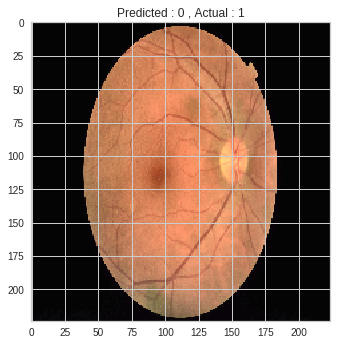

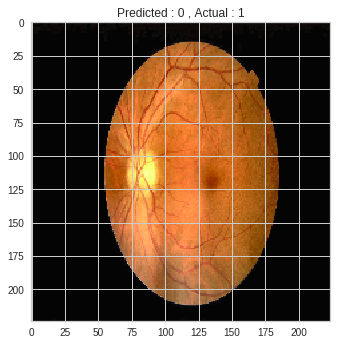

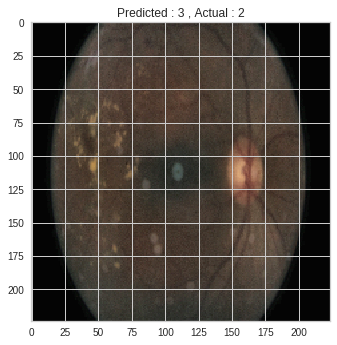

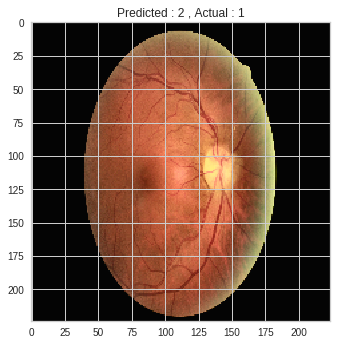

Confusion matrix, without normalization
[[122  89  17   6   9]
 [ 56  98  28  12   3]
 [ 50  47  79  45  17]
 [  5   5  17 172   5]
 [  3   1   5  19 173]]
              precision    recall  f1-score   support

    Grade: 0       0.52      0.50      0.51       243
    Grade: 1       0.41      0.50      0.45       197
    Grade: 2       0.54      0.33      0.41       238
    Grade: 3       0.68      0.84      0.75       204
    Grade: 4       0.84      0.86      0.85       201

   micro avg       0.59      0.59      0.59      1083
   macro avg       0.60      0.61      0.59      1083
weighted avg       0.59      0.59      0.59      1083



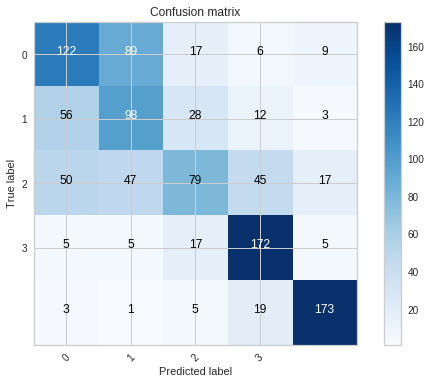

In [ ]:
evaluate_model(x_test,y_test,norm_cnn,model_file)